# SF 311 — Data Download & Quick EDA


In [1]:
import os, math, urllib.request, zipfile, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# CONFIG
DATASET_ID = "vw6y-z8j6"
LOCAL_DIR  = Path(r"/Github/SF311/data")
PARQUET    = LOCAL_DIR / "sf311_snapshot.parquet"
CSV_FILE   = LOCAL_DIR / "sf311_snapshot.csv"

LOCAL_DIR.mkdir(exist_ok=True, parents=True)

In [6]:
def download_snapshot():
    if CSV_FILE.exists():
        print("✔ CSV Exist Skip Download ")
        return
    CSV_URL = f"https://data.sfgov.org/api/views/{DATASET_ID}/rows.csv?accessType=DOWNLOAD"
    print(f"⬇ Downloading {CSV_URL.split('/')[-1]} → {CSV_FILE}")
    def progress(block_num, block_size, total_size):
        downloaded = block_num * block_size
        percent = math.floor(downloaded * 100 / total_size)
        print(f"\r{percent:3d}% ", end="")
    urllib.request.urlretrieve(CSV_URL, CSV_FILE, reporthook=progress)
    print("\n✅ Download complete")

download_snapshot()

⬇ Downloading rows.csv?accessType=DOWNLOAD → D:\py\Github\SF311\data\sf311_snapshot.csv
-412168192000% 
✅ Download complete


In [3]:
# Read CSV（1-2 min）
df = pd.read_csv(CSV_FILE, low_memory=False)
print(f"Rows: {len(df):,} · Cols: {df.shape[1]}")

Rows: 7,678,447 · Cols: 52


In [9]:
df.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Fix It Zones as of 2018-02-07,"CBD, BID and GBD Boundaries as of 2017",Central Market/Tenderloin Boundary,"Areas of Vulnerability, 2016",Central Market/Tenderloin Boundary Polygon - Updated,HSOC Zones as of 2018-06-05,OWED Public Spaces,Parks Alliance CPSI (27+TL sites),Neighborhoods,SF Find Neighborhoods
0,11376400,09/06/2019 07:40:00 AM,09/09/2019 02:43:09 PM,09/09/2019 02:43:09 PM,Closed,Case Transferred - Customer may follow up with...,MUNI Work Queue,MUNI Feedback,MUNI - Services_Service_Delivery_Facilities,601_Delay_No_Show,...,NaN,10.0,NaN,1.0,NaN,NaN,NaN,NaN,50.0,50.0
1,11380888,09/07/2019 01:32:00 AM,09/07/2019 08:22:45 AM,09/07/2019 08:22:45 AM,Closed,Case Resolved - Officer responded to request u...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Toyota Camry - 7TCM255,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,66.0,66.0
2,789051,12/14/2010 08:07:35 PM,12/16/2010 09:09:29 AM,12/16/2010 09:09:29 AM,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,91.0,91.0
3,11354620,09/01/2019 03:13:17 PM,09/01/2019 04:47:02 PM,09/01/2019 04:47:02 PM,Closed,Case Resolved - WASTE NOT FOUND,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,28.0,28.0
4,793136,12/22/2010 08:57:19 AM,03/02/2011 09:06:02 AM,03/02/2011 09:06:02 AM,Closed,See Notes tab for more details,DPW Ops Queue,Graffiti,Graffiti on Building_residential,Building_residential - Not_Offensive,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,39.0,39.0


### 1. Field Renaming & Type Preprocessing
Keep only commonly used columns and standardize naming for easier downstream use in dbt / SQL.


In [4]:
RENAME_MAP = {
    "CaseID"      : "service_request_id",
    "Opened"      : "opened_date",
    "Request Type": "service_subtype",
    "Status"      : "status",
    "Category"    : "service_name",
    "Latitude"    : "lat",
    "Longitude"   : "lon",
}
df.rename(columns=RENAME_MAP, inplace=True)

In [5]:
KEEP = list(RENAME_MAP.values()) + [
    "Closed", "Neighborhood", "Police District",
    "Source", "Media URL"
]
df = df[[c for c in KEEP if c in df.columns]]

In [7]:
#  datetime
df["Closed"] = pd.to_datetime(df["Closed"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")
df["opened_date"] = pd.to_datetime(df["opened_date"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

In [9]:
# get  Parquet
if not PARQUET.exists():
    df.to_parquet(PARQUET, index=False)
    print("Parquet saved →", PARQUET)
else:
    print("✔ Parquet already present")

✔ Parquet already present


### 2. EDA

In [10]:
# 2-1 Missing Rate
na_pct = df.isna().mean().sort_values(ascending=False) * 100
na_pct.head(10)

Media URL          63.345596
Police District     4.886014
Neighborhood        4.847699
Closed              1.656754
lat                 0.180779
lon                 0.180779
service_subtype     0.150890
Source              0.000026
status              0.000000
opened_date         0.000000
dtype: float64

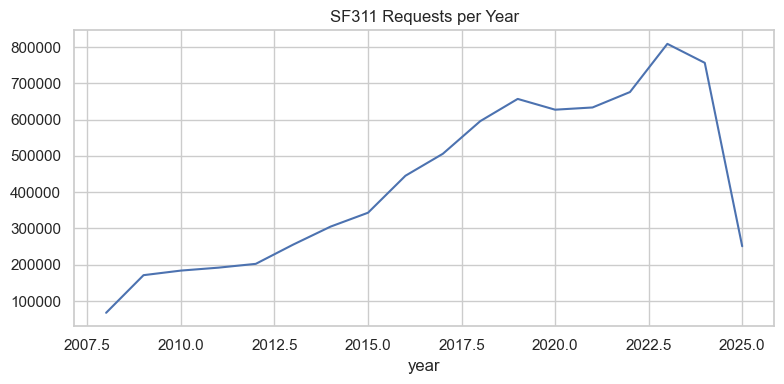

In [11]:
# 2-2 Annual Request Volume
yearly = (
    df.dropna(subset=["opened_date"])
      .assign(year=lambda d: d["opened_date"].dt.year)
      .groupby("year")["service_request_id"]
      .count()
)

yearly.plot(title="SF311 Requests per Year", figsize=(8,4))
plt.tight_layout()

In [12]:
# 2-3 Top 10 Service Subtypes
top_types = (
    df["service_subtype"]
      .value_counts()
      .head(10)
      .rename_axis("service_subtype")
      .reset_index(name="count")
)
top_types

,service_subtype,count
0,Bulky Items,1004147
1,General Cleaning,929020
2,Encampment Reports,350620
3,garbage_and_debris,304561
4,Human or Animal Waste,301299
5,request_for_service,299550
6,City_garbage_can_overflowing,278119
7,Other_Illegal_Parking,145021
8,Graffiti on Other_enter_additional_details_below,140677
9,Graffiti on Building_commercial,126104


<Axes: title={'center': 'Top 10 Request Types'}, ylabel='service_subtype'>

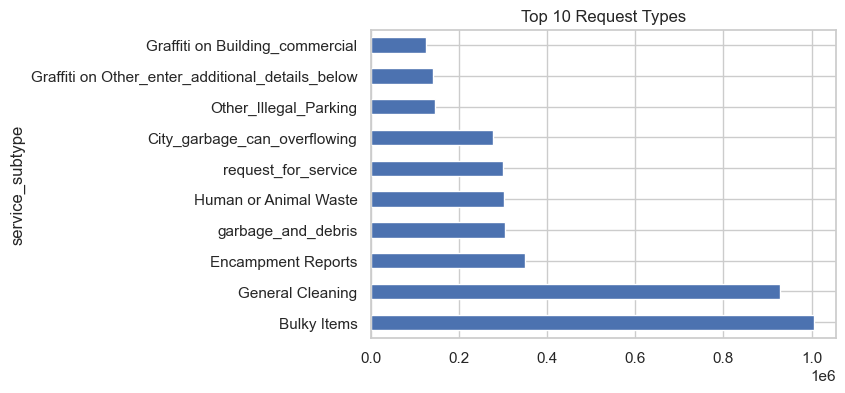

In [13]:
# 2-4 Bar Chart
top_types.set_index("service_subtype")["count"].plot.barh(figsize=(6,4), title="Top 10 Request Types")